TODO: re-go over all of this the computations and so on.

We should probably fit both a and b at the same time and not try to optimize for one then the other.

# Auto-rounding explanation

## Setup

Let's consider a step function $f$ over integer in $[x_{min}, x_{max}]$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from concrete.fhe import Configuration, Integer, univariate

from concrete import fhe
from concrete.ml.common.preprocessors import InsertRounding, TLUDeltaBasedOptimizer

# Seed to ensure reproducibility while experimenting
np.random.seed(69_420)

# Doesn't work for constant yet
# Constant function
# input_range = (-234, 283)
def jump_0(x):
    x = x.astype(np.float64)
    x = 0.75 * x - 200
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x

# Doesn't work for constant yet
# # 1 jump
# input_range = (-234, 283)
def jump_1(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 0.
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x

# # Works for this function
# 2 jumps -> like what we have in CIFAR
# input_range = (-256, 256)
def jump_2(x):
    x = x.astype(np.float64)
    x = 0.6 * x + 134.0
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x

# # 5 jumps
# x_min, x_max = -234, 283
def jump_5(x):
    x = x.astype(np.float64)
    x = 0.93 * x + 163.  # 75  80
    x = x * (x > 0)
    x = x // 69
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x

def make_step_function(n_thresholds, delta, x_min, x_max, power_of_two=False):
    """Make a step function using a TLU."""
    thresholds_ = []  # First threshold

    if power_of_two:
        th0 = np.random.randint(0, delta)
    else:
        th0 = np.random.randint(x_min, x_max)

    for index in range(n_thresholds):
        thresholds_.append(th0 + index * delta)

    thresholds = tuple(thresholds_)

    # Step size function to optimize
    def util(x):
        return sum([np.where(x >= float(threshold), 1.0, 0.0) for threshold in thresholds])

    def step_function(x):
        return univariate(util)(x).astype(np.int64)

    def f(x):
        return step_function(x.astype(np.float64))

    def constant_f(x):
        return univariate(lambda x: th0 * (1.0 - (x.astype(np.float64) * 0.0)))(x).astype(
            np.int64
        )

    if n_thresholds == 0:
        return constant_f
    return f

In [2]:
def scale_up(x, a:int=1, b=0):
    return (x * a) - b

def scale_down(x, a:int=1, b=0):
    return (x + b) / a

In [3]:
# Faster more explicit implementation of rounding
def truncation(x, lsbs_to_remove:int):
    return x - (x % 2**lsbs_to_remove)

def rounding(x, lsbs_to_remove:int):
    offsetted = x + 2**(lsbs_to_remove-1)
    return offsetted - (offsetted % 2**lsbs_to_remove)

In [4]:
def bit_width(x):
    return Integer.that_can_represent(x).bit_width

In [ ]:
def transform_inputs(input_range: np.ndarray, inputset: np.ndarray, msbs_to_keep: int, a=1, b=0):
    # TODO: add some asserts based on the expected bit-width of the range
    scaled_bitwidth = bit_width(scale_up(input_range, a=a, b=b))
    bit_width_th.append(scaled_bitwidth)
    lsbs_to_remove = scaled_bitwidth - msbs_to_keep
    return scale_down(rounding(scale_up(thresholds-1, a=a, b=b), lsbs_to_remove), a=a, b=b)

In [5]:
def plot(f, inputset, msbs_to_keep: int, a: int=1, b: int=0, title: str=""):
    # Compute target
    y = f(inputset)

    # Run with optimization
    transformed_inputset = transform_inputs(input_range=np.array([inputset.min(), inputset().max()]), inputset=inputset, msbs_to_keep=msbs_to_keep, a=a, b=b)
    transformed_y = f(transformed_inputset)

    # Compute error
    error = (y != transformed_y).sum()

    # Plot
    plt.plot(inputset, y, label="target")
    plt.plot(inputset, transformed_y, label="optimized", linestyle="--")
    plt.title(f"{title}" + ('\n' if title else '') + f"{a=}, {b=}, {msbs_to_keep=} , {lsbs_to_remove=} {error=}")
    plt.legend()

    return error

In [6]:
# Define f and x_min, x_max
function_name = "1"
if function_name == "1":
    execution_number = 4
    n_bits_from = execution_number + 2
    x_min, x_max = -(2 ** (n_bits_from)), (2 ** (n_bits_from)) - 1  # Here we assume that we take the full range
    delta = 2 ** (n_bits_from // 2)  # Constant step size assumption
    # x_max -= 4 # Check msbs-to-keep variation based on that
    f = make_step_function(execution_number, delta, x_min, x_max, True)
    input_range = (x_min, x_max)
    
elif function_name == "2":
    f = jump_5
    x_min, x_max = -234, 283
    x_min, x_max = -256, 255
    input_range = (x_min, x_max)
else:
    raise ValueError

In [7]:
# Create the inputset and compute the function
inputset = np.arange(input_range[0], input_range[1]+1, dtype=np.int64)
integer = Integer.that_can_represent(inputset)
full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)
y = f(inputset)

Text(0.5, 1.0, 'Target function')

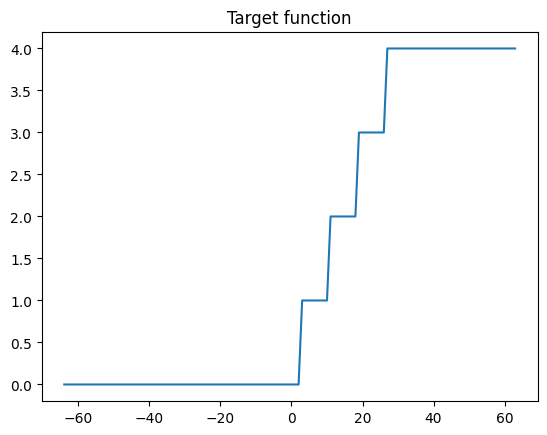

In [8]:
# Plot the function
plt.plot(inputset, y, label="target")
plt.title("Target function")

We can compute all thresholds $t_i$ and corresponding thresholds $\delta_{i}$ s.t. $\delta_i = t_{i+1} - t_{i}$

In [9]:
# Compute thresholds and deltas
change_mask = np.concatenate([[False], np.diff(y).astype(bool)])
thresholds = inputset[change_mask]
deltas = np.diff(thresholds)
thresholds, deltas

(array([ 3, 11, 19, 27]), array([8, 8, 8]))

We consider $n_{orig}$ the bit-width required to represent the input of the function.

In [10]:
input_repr = Integer.that_can_represent(inputset)
input_repr.bit_width

7

## Optimization

### Find the required number of bits to properly represent the function

The bit-width required to properly represent the function with rounding can be expressed as a function of $x_{min}, x_{max}, \delta$ for each $\delta_i$.

In [11]:
msbs_to_keep_set = set()

for delta in deltas:

    # How many elements it takes to divide [x-min, x-max] in parts of size delta
    # then take the log2 of that
    msbs_to_keep = np.ceil(
        np.log2(
            np.ceil(
                (inputset.max() - inputset.min()+1) / delta
            )
        )
    ).astype(
        np.int64
    )
    print(f"{msbs_to_keep=}")

    # Off-setting the values so that the thresholds are on a proper power of two
    # can result in an added bit
    lsbs_to_remove = int(bit_width(inputset) - msbs_to_keep)
    if lsbs_to_remove:
        for offset in np.unique(thresholds - rounding(thresholds, bit_width(inputset) - msbs_to_keep)):
            print(offset)
            msbs_to_keep = np.ceil(
                np.log2(
                    np.ceil(
                        ((inputset.max() - inputset.min() + 1) + np.abs(offset)) / delta)
                )
            ).astype(
                np.int64
            )
            print(f"{msbs_to_keep=} after offset")

            msbs_to_keep_set.add(msbs_to_keep)
    else:
        msbs_to_keep_set.add(msbs_to_keep)

msbs_to_keep = max(msbs_to_keep_set)  # + 1 -> if adds one bit

msbs_to_keep, msbs_to_keep_set

msbs_to_keep=4
3
msbs_to_keep=5 after offset
msbs_to_keep=4
3
msbs_to_keep=5 after offset
msbs_to_keep=4
3
msbs_to_keep=5 after offset


(5, {5})

Should we do something like the $gcd(\{\delta_i\}_{i})$? Or assume that $\delta_i = \delta \forall i$ but in practice $\delta_i = \delta (\pm(1,0)) \forall i$

Just rounding to keep `msbs_to_keep` is not enough.

error=4


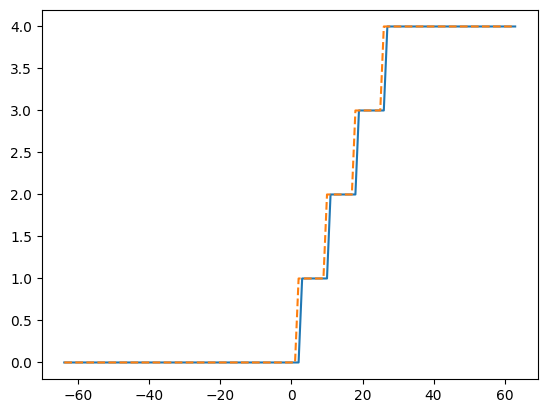

In [12]:
x_with_raw_rounding = fhe.round_bit_pattern(
    inputset, lsbs_to_remove=int(input_repr.bit_width - msbs_to_keep)
)
y_with_raw_rounding = f(x_with_raw_rounding)
plt.plot(inputset, y, label="target")
plt.plot(inputset, y_with_raw_rounding, label="rounded", linestyle="--")
error = (y != y_with_raw_rounding).sum()
print(f"{error=}")

### Finding an optimal offset

#### Exhaustive search

We can improve things by offsetting before rounding

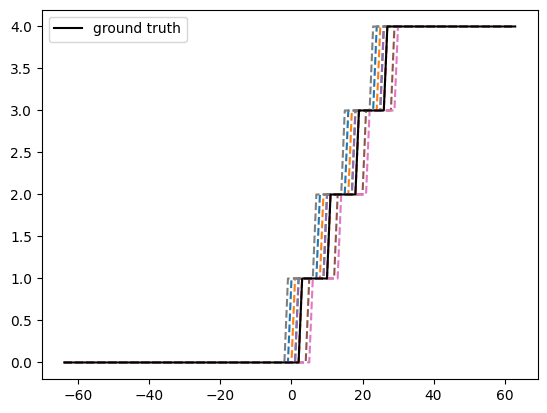

In [13]:
n = 2 ** (input_repr.bit_width - msbs_to_keep)
diff = []
offset_range = np.arange(-n, n, 1)
for offset in offset_range:
    x_off_up = inputset - offset
    x_with_offset = (
        fhe.round_bit_pattern(
            x_off_up, 
            lsbs_to_remove=int(bit_width(x_off_up) - msbs_to_keep),
        ) + offset
    )
    y_with_offset = f(x_with_offset)
    diff.append((y_with_offset != y).sum())
    plt.plot(inputset, y_with_offset, linestyle="--")
diff = np.array(diff)
plt.plot(inputset, y, color="black", label="ground truth")
plt.legend()
assert offset_range.shape == diff.shape

Text(0.5, 1.0, ' b = -1,  Min-loss=0')

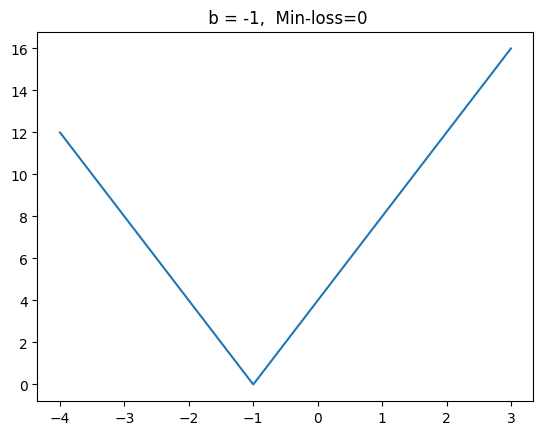

In [14]:
plt.plot(offset_range, diff)
plt.title(f" b = {offset_range[np.argmin(diff)]},  Min-loss={np.min(diff)}")

In [15]:
inputset - fhe.round_bit_pattern(
    inputset, int(bit_width(inputset) - msbs_to_keep),
)

array([ 0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,
        1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1,
       -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2,
       -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,
        0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,
        1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1,
       -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2, -1,  0,  1, -2,
       -1,  0,  1, -2, -1,  0,  1, -2, -1])

b=-1
error=0


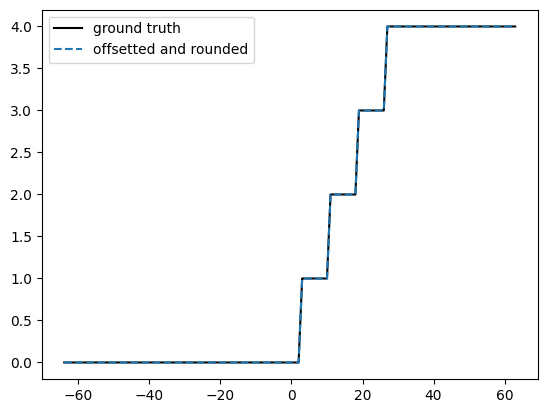

In [16]:
b = offset_range[diff == np.min(diff)][0]
print(f"{b=}")
x_up = inputset - b
x_with_offset = scale_down(
    fhe.round_bit_pattern(
        x_up, lsbs_to_remove=int(bit_width(x_up) - msbs_to_keep)
    ) + b
)
y_with_offset = f(x_with_offset)
diff[offset] = (y_with_offset != y).sum()
plt.plot(inputset, y, color="black", label="ground truth")
plt.plot(inputset, y_with_offset, linestyle="--", label="offsetted and rounded")
error = (y != y_with_offset).sum()
print(f"{error=}")
plt.legend()

### Finding an optimal offset
How about scaling such that $a \delta \approx 2^{m}$ width $m = n_{arbitrary} - n_{msbs-to-keep}$ with $n_{arbitrary} > n_{input}$

In [17]:
target_bit_width = 24

For each $\delta_i$ we can compute a $a_i$ coefficient that does this mapping.

It's given by $$\left \lfloor  \frac{2^{n_a - n_m}}{\delta_i} \right \rfloor $$

TODO: check if floor is the best or we should try with both ceil and floor, or just rint.

#### Closed form

In [18]:
from collections import Counter

a_candidates = Counter()
for delta in deltas:
    a_candidate = np.floor(2 ** (target_bit_width - msbs_to_keep) / delta).astype(np.int64)
    a_candidates[a_candidate] += 1
    
    a_candidate = np.ceil(2 ** (target_bit_width - msbs_to_keep) / delta).astype(np.int64)
    a_candidates[a_candidate] += 1


In [19]:
a_candidates

Counter({65536: 6})

In [20]:
msbs_to_keep

5

In [21]:
a = a_candidates.most_common(1)[0][0]
a

65536

In [22]:
multiplied_input_repr = Integer.that_can_represent((inputset * a))
# TODO: DEBUG
# the assert now breaks
assert multiplied_input_repr.bit_width <= target_bit_width, f"{multiplied_input_repr.bit_width=} != {target_bit_width=}"
multiplied_input_repr.bit_width

23

We can see that now our steps are almost perfectly of the correct size but there is still a slight offset to correct.

a=65536
error=4


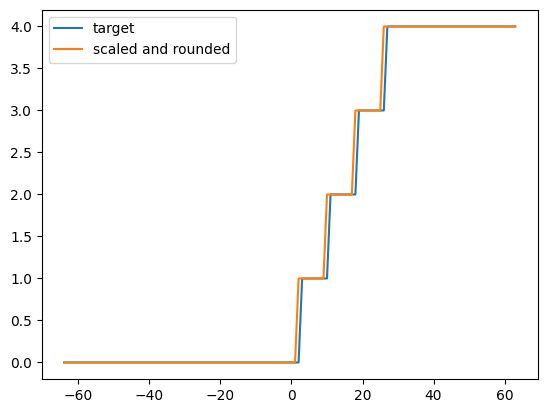

In [23]:
print(f"{a=}")
scaled_inputset = scale_up(inputset, a=a)
lsbs = Integer.that_can_represent(scaled_inputset).bit_width - msbs_to_keep
x_scaled = scale_down(fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)), a=a)
y_scaled = f(x_scaled)
plt.plot(inputset, y, label="target")
plt.plot(inputset, y_scaled, label="scaled and rounded")
error = (y != y_scaled).sum()
print(f"{error=}")
plt.legend()

### Combining offsetting and scaling

Combining scaling factor from closed form and offsetting from exhaustive search (could be closed form but still some issue with the n-bits)

In [24]:
from tqdm import tqdm

diff_f = []
bit_width_f = []
print(f"{a=}")

# Define search range
scaled_inputset = scale_up(inputset, a=a)
lsbs = Integer.that_can_represent(scaled_inputset).bit_width - msbs_to_keep
bs_f = np.arange(-2 ** (lsbs-1), 2 ** (lsbs-1) - 1, 1)

# Search
input_bounds_arr = np.array([x_min, x_max])
for b in tqdm(bs_f):
    # Method 1: compute the function
    x_with_offset = transform_inputs(input_range=input_bounds_arr, inputset=inputset, msbs_to_keep=msbs_to_keep, a=a, b=b)
    y_with_offset = f(x_with_offset)

    # Compute error
    error = (y_with_offset != y).sum()
    
    diff_f.append(error)

a=65536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262143/262143 [00:08<00:00, 30265.54it/s]


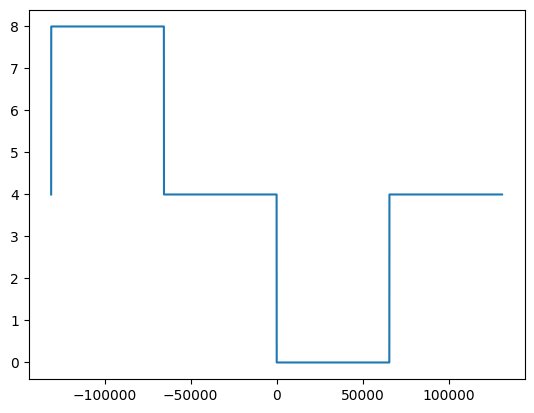

In [25]:
plt.plot(bs_f, diff_f)

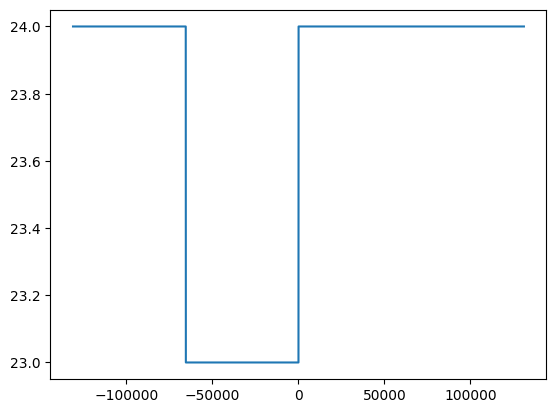

In [26]:
plt.plot(bs_f, bit_width_f)

In [27]:
diff_f = np.array(diff_f)
argmin_f = np.argmin(diff_f)
argmin_f, bs_f[argmin_f], diff_f[argmin_f]  # Should take the argmin based on abs value of b too

(131073, 1, 0)

error


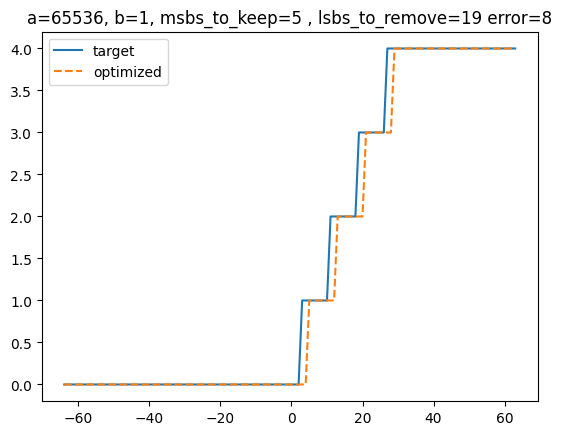

In [28]:
err = plot(f, inputset, msbs_to_keep, a=a, b=bs_f[argmin_f])
if err != diff_f[argmin_f]:
    print("error")

65536

In [30]:
from tqdm import tqdm

diff_th = []
bit_width_th = []
print(f"{a=}")

# Define search range
scaled_inputset = scale_up(inputset, a=a)
lsbs = Integer.that_can_represent(scaled_inputset).bit_width - msbs_to_keep
bs_th = np.arange(-2 ** (lsbs-1), 2 ** (lsbs-1) - 1, 1)

# Search
input_bounds_arr = np.array([x_min, x_max])
for b in tqdm(bs_th):
    # Method 2: compute only the thresholds
    scaled_bitwidth = bit_width(scale_up(input_bounds_arr, a=a, b=b))
    bit_width_th.append(scaled_bitwidth)
    lsbs_to_remove = scaled_bitwidth - msbs_to_keep
    # error = np.abs(thresholds - scale_down(rounding(scale_up(thresholds, a=a, b=b), lsbs_to_remove), a=a, b=b)).sum()
    error = (((thresholds-1) - scale_down(rounding(scale_up(thresholds-1, a=a, b=b), lsbs_to_remove), a=a, b=b))**2).sum()
    # It's not a == that we are searching for but probably more something like a -1 <= x <= 1 or something like that
    
    diff_th.append(error)

a=65536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262143/262143 [00:04<00:00, 56378.85it/s]


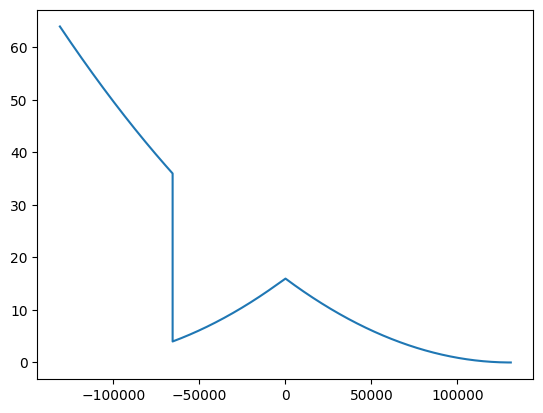

In [31]:
plt.plot(bs_th, diff_th)

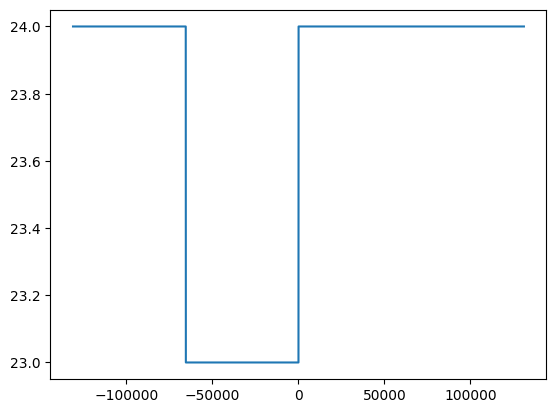

In [32]:
plt.plot(bs_f, bit_width_th)

In [33]:
diff_th = np.array(diff_th)
argmin_th = np.argmin(diff_th)
bs_th[argmin_th], diff_th[argmin_th]  # Should take the argmin based on abs value of b too

(131070, 3.725290298461914e-09)

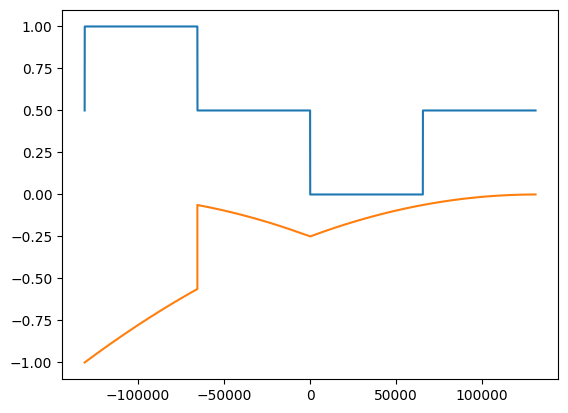

In [34]:
plt.plot(bs_f, diff_f/diff_f.max())
plt.plot(bs_th, -diff_th/diff_th.max())

In [35]:
diff_th.argmax(), diff_f.argmin()

(0, 131073)

In [36]:
diff_th = np.array(diff_th)
argmin_th = np.argmax(diff_th)
bs_th[argmin_th], diff_th[argmin_th]

(-131072, 64.0)

4

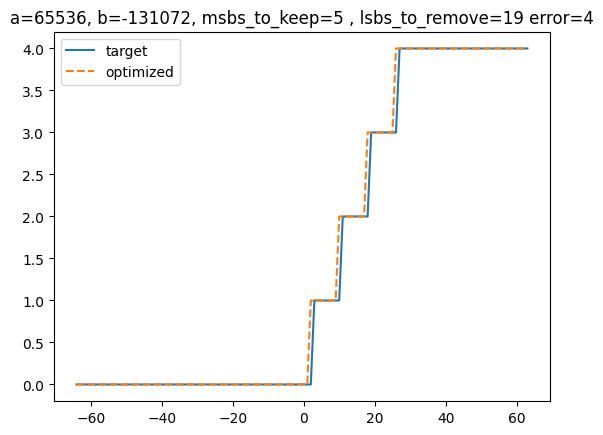

In [37]:
plot(f, inputset, msbs_to_keep, a=a, b=bs_th[argmin_th])

In [38]:
raise ValueError()

ValueError: 

### Searching for a closed form

In [ ]:
scaled_bitwidth_ = Integer.that_can_represent(inputset * a).bit_width
lsbs_ = scaled_bitwidth_ - msbs_to_keep
thresholds_ = thresholds * a
b_candidates = fhe.round_bit_pattern(thresholds_, lsbs_to_remove=int(lsbs_)) - thresholds_
b_candidates -= 2 ** (lsbs_ - 1)
b_candidates *= -1
b_candidates

In [ ]:
b_candidates.max() - b_candidates.min()

In [ ]:
diff = []
bs = np.arange(b_candidates.min(), b_candidates.max()+1)
for b in tqdm(bs):
    scaled_inputset = scale_up(inputset, a=a, b=b)
    lsbs = Integer.that_can_represent(scaled_inputset).bit_width - msbs_to_keep
    x_with_offset = scale_down(fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)), b=b, a=a)
    y_with_offset = f(x_with_offset)
    error = (y != y_with_offset).sum()
    diff.append(error)
diff = np.array(diff)

In [ ]:
plt.plot(bs, diff)
plt.vlines(b_candidates, diff.min(), diff.max(), linestyle="--", color="grey")

In [ ]:
diff = np.array(diff)
argmin = np.argmin(diff)
bs[argmin], diff[argmin]

In [ ]:
b = bs[argmin]
print(f"{a=}, {b=}")
scaled_inputset = scale_up(inputset, a=a, b=b)
lsbs = Integer.that_can_represent(scaled_inputset).bit_width - msbs_to_keep
x_with_offset = scale_down(fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)),b=b, a=a)
y_with_offset = f(x_with_offset)
plt.plot(inputset, y, label="target")
plt.plot(inputset, y_with_offset, label="scaled, offsetted and rounded", linestyle="--")
plt.legend()
print("error:", (y != y_with_offset).sum())

In [ ]:
raise ValueError

# Fuck it let's do the maths properly

## Setting
We have a function $f : x \rightarrow y$ over $\mathbb{Z} \cap [x_{\min}, x_{\max}] \rightarrow \mathbb{Z} \cap [y_{\min}, y_{\max}]$.

Let's write $\mathbb{X} = \mathbb{Z} \cap [x_{\min}, x_{\max}] $, it can be encoded over $n_{\mathbb{X}}$ bits.

$f$ being a function over a subset of $\mathbb{Z}$ we can write it as:

$$ f(x) = \sum_{i = 0}^{n_{\text{steps}}} a_i \mathbb{1}(x >= t_i)$$


with $t_{i+1} > t_{i} \forall i$.

Thus we can define $ \delta_i = t_{i+1} - t_{i} \forall i$.

Let's also define a rounding function $r(x, n) = x - (x \mod 2^{n})$

## Questions

1. How do we find the least number of bits required to properly represent this function over its whole definition range.
2. How do we find the affine mapping that allows us to properly represent the function using this least number of bits. (we are in FHE so the only operations that we can do are affine)

## Some solutions

### Least number of bits

We have a range $[x_{\min}, x_{\max}]$ and a set of ${(t_i, \delta_i)}_{i \in [ 0 .. n_{\text{steps}} - 1 ]}$

$$n_{\text{required}} = \left \lceil  \frac{x_{\max} - x_{\min}}{gcd(\delta_0, ..., \delta_{n_{\text{steps}}-1})} \right \rceil$$

### Affine mapping

How do we find a linear mapping $l(x) = a * x + b$ such that 


We can compute all thresholds $t_i$ and corresponding thresholds $\delta_{i}$ s.t. $\delta_i = t_{i+1} - t_{i}$

### Side quest: re-implementing rounding and truncation

Custom implementation is less than 2x faster. A few micro-seconds with std in the nano-seconds (less std with the pure numpy than cp)

In [ ]:
raise ValueError()

In [ ]:
from itertools import product
from tqdm.auto import tqdm

a_candidates = np.arange(1, 2**(msbs_to_keep+2))
b_candidates = np.arange(-2**lsbs, 2**lsbs)
errors = np.empty(shape=(len(a_candidates), len(b_candidates)))

# No solution with 0 error at 4-bits
# This is due to the increase in bit-width because of the offset when min-max+-offset 
# increases the bit-width
# msbs_to_keep = 5
errors = np.empty(shape=(len(a_candidates), len(b_candidates)))
bit_widths = np.empty(shape=(len(a_candidates), len(b_candidates)))

for (a_i, a_c), (b_i, b_c) in tqdm(product(enumerate(a_candidates), enumerate(b_candidates))):
    scaled_bitwidth = bit_width(scale_up(inputset, a=a_c, b=b_c))
    lsbs_to_remove = scaled_bitwidth - msbs_to_keep
    errors[a_i, b_i] = (thresholds != scale_down(rounding(scale_up(thresholds, a=a_c, b=b_c), lsbs_to_remove),a=a_c, b=b_c)).sum()
    bit_widths[a_i, b_i] = scaled_bitwidth

In [ ]:
plt.title("Threshold error count with affine transformation and rounding")
plt.ylabel("a")
plt.yticks(ticks=np.arange(len(a_candidates)), labels=a_candidates)
plt.xlabel("b")
plt.xticks(ticks=np.arange(len(b_candidates)), labels=b_candidates)
plt.imshow(errors, interpolation='none')
errors, errors.min()

In [ ]:
ind = np.unravel_index(np.argmin(errors, axis=None), errors.shape)
ind, a_candidates[ind[0]], b_candidates[ind[1]], errors[ind]

In [ ]:
a_v, b_v = a_candidates[ind[0]], b_candidates[ind[1]]
print(a_v, b_v)
scaled_inputset = scale_up(inputset, a=a_v, b=b_v)
lsbs = bit_width(scaled_inputset) - msbs_to_keep
x_with_offset = scale_down(fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)), a=a_v, b=b_v)
y_with_offset = f(x_with_offset)
plt.plot(inputset, y, label="target")
plt.plot(inputset, y_with_offset, label="scaled offsetted and rounded", linestyle="--")
plt.legend()
error = (y != y_with_offset).sum()
print(f"{error=}")

In [ ]:
# solution_mask = errors == np.min(errors)
# a_candidates[solution_mask].argmin()
# np.stack([a_candidates], solution_mask.shape[1])

In [ ]:
thresholds - fhe.round_bit_pattern(thresholds, 4)

In [ ]:
plt.title("Bit-width of inputset after affine transform")
plt.ylabel("a")
plt.yticks(ticks=np.arange(len(a_candidates)), labels=a_candidates)
plt.xlabel("b")
plt.xticks(ticks=np.arange(len(b_candidates)), labels=b_candidates)
plt.imshow(bit_widths, interpolation='none')
bit_widths.min(), bit_widths.max()

In [ ]:
# (x_max - x_min + offset) / delta

In [ ]:
# Can we do the search without using the function itself but just the thresholds?

from itertools import product
from tqdm.auto import tqdm

a_candidates = np.arange(1, 2**(msbs_to_keep))
b_candidates = np.arange(-2**lsbs, 2**lsbs)  # Properly define this range
errors = np.empty(shape=(len(a_candidates), len(b_candidates)))

# No solution with 0 error at 4-bits
# This is due to the increase in bit-width because of the offset when min-max+-offset 
# increases the bit-width
# msbs_to_keep = 5

# Pre-allocate the memory for the results
errors = np.empty(shape=(len(a_candidates), len(b_candidates)))
bit_widths = np.empty(shape=(len(a_candidates), len(b_candidates)))

input_bounds_arr = np.array([x_min, x_max], dtype=np.int64)

# TODO: figure out if this could benefit from numba jit?
# Using the thresholds as estimates of the correctness of the approximation we can go much faster than computing the whole function
for (a_i, a_c), (b_i, b_c) in tqdm(product(enumerate(a_candidates), enumerate(b_candidates)), total=len(a_candidates)*len(b_candidates)):
    scaled_bitwidth = bit_width(scale_up(input_bounds_arr, a=a_c, b=b_c))
    lsbs_to_remove = scaled_bitwidth - msbs_to_keep
    errors[a_i, b_i] = (thresholds != scale_down(rounding(scale_up(thresholds, a=a_c, b=b_c), lsbs_to_remove),a=a_c, b=b_c)).sum()
    bit_widths[a_i, b_i] = scaled_bitwidth

ind = np.unravel_index(np.argmin(errors, axis=None), errors.shape)
ind, a_candidates[ind[0]], b_candidates[ind[1]], errors[ind]